# Tarea 5 - Equivalent widths of absorption lines

Find the curve of growth: equivalent width versus line strength.  Assume a Voigt (Hjelming) line profile and a Milne-Eddington model for the line formation.


In [29]:
import numpy as np
from astropy.convolution import convolve_fft, Gaussian1DKernel
from scipy.integrate import quad
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns



## The absorption profile 

The absorption profile $\phi_\nu$ is the convolution of a Gaussian and a Lorentzian.  We construct the Lorentzian explicitly and then use FFT to convolve with the Gaussian.  We use a dimensional frequency shift, `u`, which is in units of the Doppler width: $u \equiv (\nu - \nu_0) / \Delta \nu_{\text{D}}$.

In [4]:
def Lorentz(u, a=1e-6):
    return (a / np.pi) / (a**2 + u**2)

Test the Lorentz function

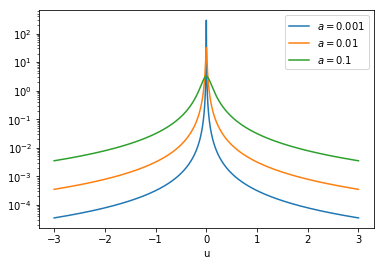

In [15]:
fig, ax = plt.subplots()
ugrid = np.linspace(-3.0, 3.0, 10000)
for a in reversed([0.1, 0.01, 0.001]):
    ax.plot(ugrid, Lorentz(ugrid, a), label=f"$a = {a}$")
ax.legend()
ax.set(yscale="log", xlabel="u")
None

So, this seems to work.  Note that the central peak is higher for smaller `a`, since it is normalized to unit area under the curve.

### Convolution method for integral (mainly works, if we are careful)

First we use the default parameters for FFT convolution in `astropy.convolution`. 

**Note:** *This does not work well, as we will see.*

In [95]:
ugrid = np.linspace(-10.0, 10.0, 1001)
ustep = ugrid[1] - ugrid[0]
kernel = Gaussian1DKernel(stddev=1.0/np.sqrt(2)/ustep)
def H_conv_naive(u, a=1e-6):
    return convolve_fft(Lorentz(u, a), kernel)

Note that the kernel width must be given in pixels, not in units of `u`, so we first calculate the pixel size `ustep` and use a standard deviation of `1.0/ustep` pixels, which corresponds to 1 in units of `u`.

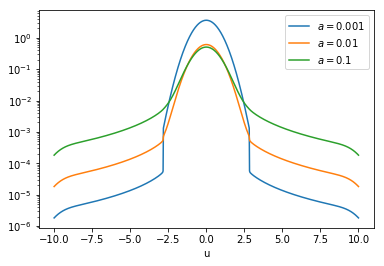

In [96]:
fig, ax = plt.subplots()
for a in reversed([0.1, 0.01, 0.001]):
    ax.plot(ugrid, H_conv_naive(ugrid, a), label=f"$a = {a}$")
ax.legend()
ax.set(yscale="log", xlabel="u")
None

So, there are three problems with this:

1. The turn down at the left and right edges.  
2. The jump at $u = \pm 4$.
3. The normalization seems wrong

We fix these as follows:

1. Extend the $u$ range to $[-11, 11]$, but only plot the range $[-10, 10]$
2. Use the `x_size` optional parameter to make the kernel array the same size as `ugrid`, rather than the default of $8 \sigma$. 
3. Just use more points (I don't understand why this makes a difference, and the normalization still doesn't look quite right).

I also plot the pure Gaussian kernel in black.

In [158]:
def H_conv(u, a=1e-6):
    ustep = u[1] - u[0]
    kernel_wide = Gaussian1DKernel(stddev=1.0/np.sqrt(2)/ustep, x_size=len(u))
    kernel_wide.normalize("peak")
    result = convolve_fft(Lorentz(u, a), kernel_wide)
    return np.sqrt(np.pi)*result/np.trapz(result, u)

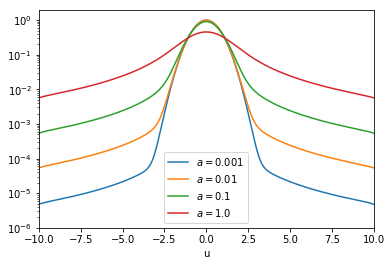

In [159]:
ugrid = np.linspace(-11.0, 11.0, 10001)
fig, ax = plt.subplots()
for a in reversed([1.0, 0.1, 0.01, 0.001]):
    ax.plot(ugrid, H_conv(ugrid, a), label=f"$a = {a}$")
ax.legend()
ax.set(yscale="log", xlabel="u", xlim=[-10.0, 10.0], ylim=[1e-6, None])
None

### Quadrature method for integral (fails for small damping parameter)

In [113]:
def Gauss(u):
    return np.exp(-u**2)

In [118]:
def H_integrand(y, u, a):
    return Gauss(y)*Lorentz(u-y, a)

In [119]:
def H_quad_scalar(u, a):
    result, error = quad(H_integrand, -np.infty, np.infty, args=(u, a))
    return result

In [120]:
@np.vectorize
def H_quad(u, a):
    return H_quad_scalar(u, a)

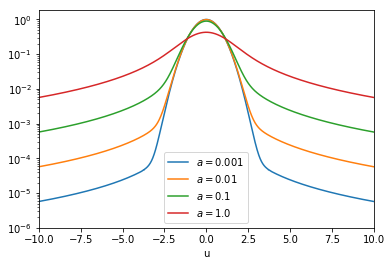

In [148]:
ugrid = np.linspace(-10.0, 10.0, 1000)
fig, ax = plt.subplots()
for a in reversed([1.0, 0.1, 0.01, 0.001]):
    ax.plot(ugrid, H_quad(ugrid, a), label=f"$a = {a}$")
ax.legend()
ax.set(yscale="log", xlabel="u", xlim=[-10.0, 10.0], ylim=[1e-6, None])
None

So that is fine for those $a$ values, although it is much slower than the FFT method.  And, the normalization looks fine, which is an improvement. But what if we make $a$ smaller? 

/Users/will/anaconda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


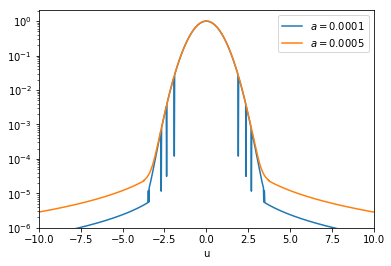

In [149]:
ugrid = np.linspace(-10.0, 10.0, 1000)
fig, ax = plt.subplots()
for a in reversed([0.0005, 0.0001]):
    ax.plot(ugrid, H_quad(ugrid, a), label=f"$a = {a}$")
ax.legend()
ax.set(yscale="log", xlabel="u", xlim=[-10.0, 10.0], ylim=[1e-6, None])
None

We can put off the inevitable by using more points, but this makes everything painfully slow.

### Fadeeva function method (this is the best method: fast and accurate)

The Fadeeva function ([see Wikipedia](https://en.wikipedia.org/wiki/Faddeeva_function)) is the scaled complementary error function of complex argument, and the Voigt function is its real part.  It is implemented as `scipy.special.wofz`. 

In [98]:
from scipy.special import wofz

def H_wofz(u, a):
    return np.real(wofz(u + 1j*a))

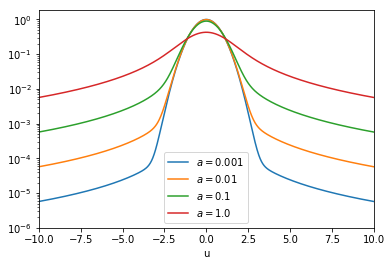

In [151]:
ugrid = np.linspace(-10.0, 10.0, 1000)
fig, ax = plt.subplots()
for a in reversed([1.0, 0.1, 0.01, 0.001]):
    ax.plot(ugrid, H_wofz(ugrid, a), label=f"$a = {a}$")
ax.legend()
ax.set(yscale="log", xlabel="u", xlim=[-10.0, 10.0], ylim=[1e-6, None])
None

### McLean algorithm method (very bad for small $a$) 

In [100]:
from astropy.modeling.functional_models import Voigt1D


We need to convert from Doppler width to FWHM, which is factor of $2 \sqrt{\ln 2}$

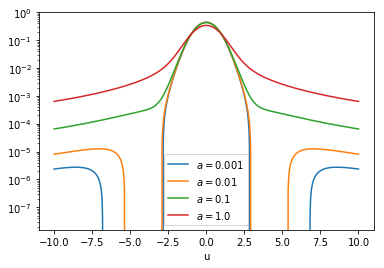

In [154]:
ugrid = np.linspace(-10.0, 10.0, 1000)
fig, ax = plt.subplots()
FWHM = 2*np.sqrt(np.log(2))
for a in reversed([1.0, 0.1, 0.01, 0.001]):
    H_McL = Voigt1D(fwhm_G=FWHM, amplitude_L=1.0, fwhm_L=a/2)
    ax.plot(ugrid, H_McL(ugrid)/a, label=f"$a = {a}$")
ax.legend()
ax.set(yscale="log", xlabel="u")
None   

This is terrible.  It goes negative for $a < 0.1$!

It turns out that there is a recent paper that points out these problems: 

* [Schreier (2008) JQSRT 213, 13](https://doi.org/10.1016/j.jqsrt.2018.03.019) *Comments on the Voigt function implementation in the Astropy and SpectraPlot.com packages* 

### Comparison of methods

In [129]:
def H_approx(u, a):
    return Gauss(u) + a/(1.0 + u**2)/np.sqrt(np.pi)

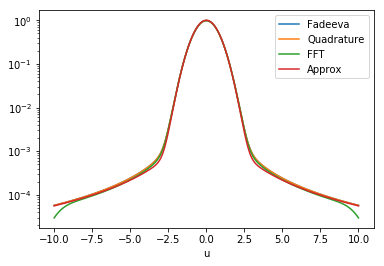

In [160]:
a = 0.01
ugrid = np.linspace(-10.0, 10.0, 1001)
fig, ax = plt.subplots()
for H, name in [
    [H_wofz, "Fadeeva"],
    [H_quad, "Quadrature"],
    [H_conv, "FFT"],
    [H_approx, "Approx"],
]:
    ax.plot(ugrid, H(ugrid, a), label=name)
ax.legend()
ax.set(yscale="log", xlabel="u")
None   

### Timings

In [162]:
for H, name in [
    [H_wofz, "Fadeeva"],
    [H_quad, "Quadrature"],
    [H_conv, "FFT"],
    [H_approx, "Approx"],
]:
    print(f"Timing for {name} method:")
    %timeit H(ugrid, a)
    print()

Timing for Fadeeva method:
225 µs ± 24.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Timing for Quadrature method:
1.11 s ± 25.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Timing for FFT method:
1.78 ms ± 81.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Timing for Approx method:
34.5 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)



### Conclusions about methods

* The Fadeeva method is by far the best.  It is very efficient and accurate.
* Quadrature is accurate for $a \ge 0.001$, but it is 5000 times slower.
* FFT is 10 times slower and suffers from edge effects
* McLean is hopelessly inaccurate for $a < 0.1$


## The line flux profile $F_\nu$

We define the frequency-dependent line opacity relative to the continuum as $\beta_\nu = \beta_0 \phi_\nu$, where $\beta_0 = \chi_\ell / \kappa_c$.  In the Milne–Eddington approximation for LTE lines, the line absorption depth can be written as (see Hubeny & Mihalas, eq.~[17.189])
$$
A_\nu = \frac{A_0 \beta_\nu}{1 + \beta_\nu}
$$
where $A_0$ is the infinitely opaque limiting absorption depth, $A_0 = \bigl(1 + 3 B_0 / 2 B_1 \bigr)^{-1}$, which depends on how the LTE source function varies with depth: $B_\nu(\tau_c) = B_0 + B_1 \tau_c$.  The line flux is given by $F_\nu = F_c (1 - A_\nu)$. 


In [163]:
def A(u, a, beta0, A0):
    """Absorption depth"""
    beta_nu = beta0*H_wofz(u, a)
    return A0*beta_nu/(1.0 + beta_nu)

For illustration, we use $A_0 = 0.5$ and $a = 0.001$.

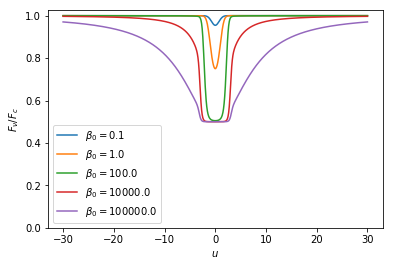

In [175]:
ugrid = np.linspace(-30.0, 30.0, 1001)
fig, ax = plt.subplots()
A0 = 0.5
a = 1.e-3
for beta0 in [0.1, 1.0, 100.0, 1e4, 1e5]:
    label = fr"$\beta_0 = {beta0}$"
    ax.plot(ugrid, 1.0 - A(ugrid, a, beta0, A0), label=label)
ax.legend()
ax.set(ylim=[0.0, None], xlabel="$u$", ylabel=r"$F_\nu/F_c$")
None

This shows the transition from weaker to stronger lines, showing saturation for $\beta_0 \ge 100$ and damping wings for $\beta_0 \ge a^{-1}$. 

## The equivalent width, $W_\nu$

Defined as $W_\nu = \int_0^\infty A_\nu \, d\nu$.

In [189]:
def W(a, beta0, A0):
    """Equivalent width in units of the Doppler width"""
    result, error = quad(A, -np.infty, np.infty, args=(a, beta0, A0))
    return result

Integration limits of $u$ are $[-\infty, \infty]$.  We just send those in directly, and let the quadrature routine sort it out.

In [190]:
from astropy.table import Table

Table(rows=[(x, W(a, x, A0)) for x in [0.1, 1.0, 100.0, 1e4, 1e6]], names=["beta0", "W"])

beta0,W
float64,float64
0.1,0.0828358366521
1.0,0.53645721327
100.0,2.12332875198
10000.0,4.62122393783
1000000.0,37.3704253675


That seems to work.

## The curve of growth

This is just a plot of $W_\nu(\beta_0) \,/\, (A_0 \, \Delta\nu_D)$.

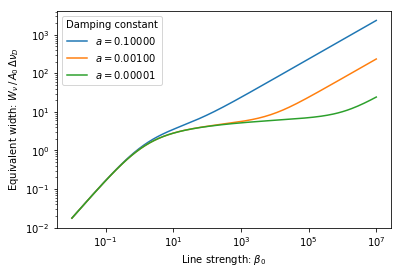

In [200]:
bgrid = np.logspace(-2.0, 7.0, 200)
fig, ax = plt.subplots()
for a in 1e-1, 1e-3, 1e-5:
    label = f"$a = {a:.5f}$"
    wgrid = np.array([W(a, b, A0)/A0 for b in bgrid])
    ax.plot(bgrid, wgrid, label=label)
ax.legend(title="Damping constant")
ax.set(
    xscale="log", yscale="log", 
    xlabel=r"Line strength: $\beta_0$",
    ylabel=r"Equivalent width: $W_\nu \,/\, A_0\, \Delta\nu_D$"
)
None

So, we can clearly see the three regimes: linear, saturated, and damping (square-root).